In [6]:
%run key_imports.py
%run bs.py
%run nn_archi.py
%run utils.py

In [7]:
"""
Fix Random Seed
"""
SEED = 42
rng = default_rng(SEED)

"""
Fix Terminal maturity
"""

T = 1
N_TIMES = 32
dt = T / N_TIMES
ts = np.linspace(0, T, N_TIMES + 1)

"""
Define State Variables
"""
N_SAMPLES = 2048
SKs = rng.uniform(-3, 1, N_SAMPLES) # log-moneyness
sigma = rng.uniform(1e-6, 1, N_SAMPLES) # volatilty


"""
Define Brownian Increments
"""
W = rng.standard_normal((N_SAMPLES, N_TIMES)) * np.sqrt(dt)

"""
Simulate St paths
"""
Sts = np.zeros((N_SAMPLES, N_TIMES + 1))
Sts[:, 0] = SKs
deltas = np.zeros((N_SAMPLES, N_TIMES + 1))
vegas = np.zeros((N_SAMPLES, N_TIMES + 1))
for i in range(N_TIMES):
    Sts[:,i + 1] = gbm_step(Sts[:,i], dt, sigma, W[:,i])
    vec_fun = lambda x, dt, sigma, w: grad(gbm_step, argnums = 0)(x, dt, sigma, w)
    deltas[:, i] = jnp.vectorize(vec_fun)(Sts[:,i], dt, sigma, W[:,i])
bs_call_payoff = lambda x: jnp.maximum(jnp.exp(x) - 1.0, 0)
y = np.array(bs_call_payoff(Sts[:,-1]))
deltas[:, -1] = jnp.vectorize(grad(bs_call_payoff))(Sts[:, -1])
final_grad = jnp.vectorize(grad(bs_call_payoff))(Sts[:,-1])
deltas = np.cumprod(deltas[:, ::-1], axis = 1) * np.array(final_grad).reshape((-1, 1))

"""
Combine to create dataset
"""

feat_names = ['log(S/K)', 'ttm']
f_to_i = lambda x: feat_names.index(x)

# Fix terminal payoff, go forward in time
y = np.maximum(np.exp(Sts[:,-1]) - 1, 0)
Xs = np.vstack([Sts[:, :-1].reshape(-1),
                (sigma.reshape((-1, 1)) * np.sqrt(T - ts[:-1])).reshape(-1)
                ]).T
Xs = Xs.astype(np.float32)
ys = np.repeat(y, N_TIMES)
print(Xs.shape, ys.shape)
assert Xs.shape[0] == ys.shape[0]

"""
Writeout to csv
"""
X_df = pd.DataFrame(Xs, columns = feat_names)
X_df['pathwise_delta'] = deltas[:, :-1].reshape(-1)
X_df['call_payoff'] = ys
X_df['call_true'] = jax_BS_call(Xs[:,0], Xs[:,1])
X_df['digital_payoff'] = (ys > 0) * 1
X_df['digital_true'] = jax_BS_digital(Xs[:,0], Xs[:,1])
X_df['true_d_log(S/K)'], X_df['true_d_ttm'] = first_order_greeks(moneyness = Xs[:,0], ttm = Xs[:,1])
X_df['true_d2_log(S/K)'] = second_order_greek(moneyness = Xs[:,0], ttm = Xs[:,1])
X_df['path'] = X_df.index // N_TIMES
X_df.to_csv("bs.csv", index=False)
display(X_df)

(65536, 2) (65536,)


,log(S/K),ttm,pathwise_delta,call_payoff,call_true,digital_payoff,digital_true,true_d_log(S/K),true_d_ttm,true_d2_log(S/K),path
0,0.095824,0.146744,1.51132,0.229357,1.243302e-01,1,7.189180e-01,8.432480e-01,3.372524e-01,3.141483e+00,0
1,0.102578,0.144433,1.51132,0.229357,1.293414e-01,1,7.382615e-01,8.676028e-01,3.254791e-01,3.121096e+00,0
2,0.160319,0.142084,1.51132,0.229357,1.838535e-01,1,8.548112e-01,1.038665e+00,2.281222e-01,2.644206e+00,0
3,0.197072,0.139696,1.51132,0.229357,2.233434e-01,1,9.100192e-01,1.133362e+00,1.623651e-01,2.295636e+00,0
4,0.188758,0.137267,1.51132,0.229357,2.135811e-01,1,9.043070e-01,1.117888e+00,1.699253e-01,2.355812e+00,0
...,...,...,...,...,...,...,...,...,...,...,...
65531,-0.841867,0.127759,0.00000,0.000000,2.687234e-13,0,1.432367e-11,1.459434e-11,9.737861e-11,7.767978e-10,2047
65532,-0.832462,0.114271,0.00000,0.000000,1.604287e-15,0,1.051338e-13,1.067386e-13,7.857384e-13,6.982788e-12,2047
65533,-0.875811,0.098962,0.00000,0.000000,3.079335e-21,0,2.805760e-19,2.837034e-19,2.528183e-18,2.583044e-17,2047
65534,-0.868903,0.080802,0.00000,0.000000,1.363924e-29,0,1.839564e-27,1.852612e-27,2.001728e-26,2.495884e-25,2047


Text(0.5, 1.0, 'True payoffs vs Monyness')

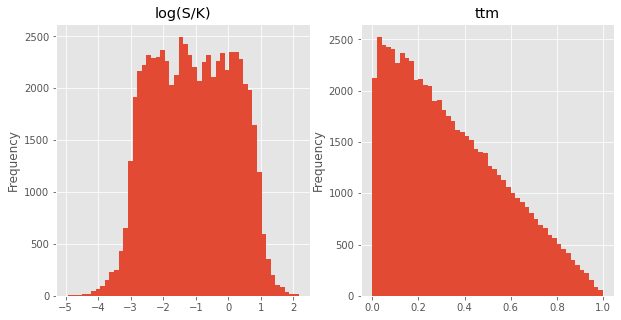

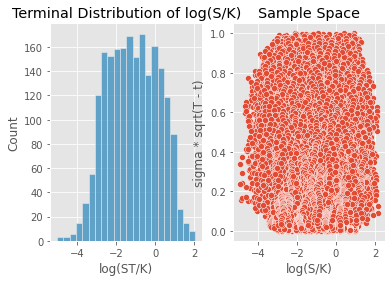

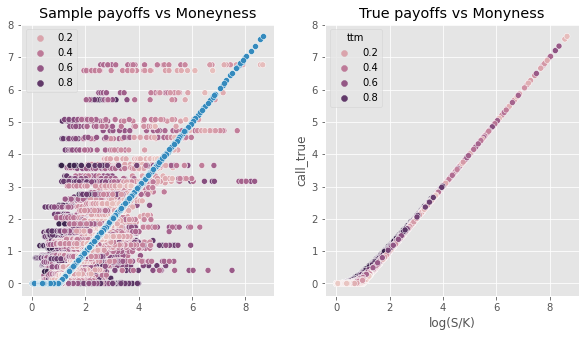

In [7]:
"""
Visualise data
"""
# Marginal Distributions of Parameter Space
fig, ax = plt.subplots(figsize=(5 * len(feat_names), 5), ncols = len(feat_names))
for i in range(len(feat_names)):
    X_df.iloc[:, i].plot(kind = 'hist', ax = ax[i], bins = 50)
    ax[i].set_title(feat_names[i])
# Terminal Distribution of underlying
fig, ax = plt.subplots(ncols = 2)
sns.scatterplot(x = Xs[:, f_to_i("log(S/K)")], y = Xs[:, f_to_i("ttm")], ax = ax[1])
sns.histplot(Sts[:, -1], ax = ax[0])
ax[0].set_title("Terminal Distribution of log(S/K)")
ax[0].set_xlabel("log(ST/K)")
ax[1].set_title("Sample Space")
ax[1].set_xlabel("log(S/K)")
ax[1].set_ylabel("sigma * sqrt(T - t)")
# sample payoff, intrinsic val v S/K

fig, ax = plt.subplots(ncols = 2, figsize=(10, 5))
intrinsic_val = np.maximum(np.exp(Xs[:,f_to_i("log(S/K)")]) - 1.0, 0)
sns.scatterplot(x = np.exp(Xs[:,f_to_i("log(S/K)")]), y = ys, hue = Xs[:, f_to_i("ttm")], ax = ax[0])
sns.scatterplot(x = np.exp(Xs[:,f_to_i("log(S/K)")]), y = intrinsic_val, ax = ax[0])
ax[0].set_title("Sample payoffs vs Moneyness")
sns.scatterplot(x = np.exp(X_df['log(S/K)']), y = X_df['call_true'], hue = X_df['ttm'], ax = ax[1])
ax[1].set_title("True payoffs vs Monyness")

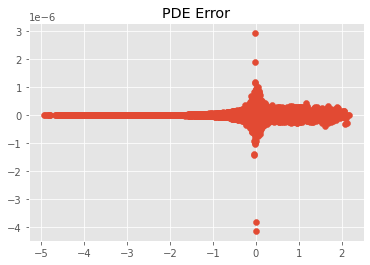

In [8]:
true_pde_err = bs_log_pde_err(X_df['log(S/K)'], X_df['ttm'], 
                          X_df['true_d_ttm'], 
                          X_df['true_d_log(S/K)'], 
                          X_df['true_d2_log(S/K)'])
assert np.allclose(np.mean(true_pde_err), 0)